In [1]:
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from shapely import box
import pandas as pd
import pyproj

import tempfile
from sklearn.metrics import ConfusionMatrixDisplay
import geofileops as gfo
import logging

from spatial_utils.geometric import merge_classified_polygons_by_voting
from spatial_utils.geospatial import ensure_projected_CRS

In [ ]:
METADATA_FILE = Path("/ofo-share/drone-imagery-organization/ARCHIVE_3c_metadata-extracted/all-mission-polygons-w-metadata.gpkg")
PREDS_FOLDER = Path("/ofo-share/repos-david/UCNRS-experiments/data/final/post_processed_shifted_predictions_high_conf")

ENSURE_NONOVERLAPPING = True
#Quail, BORR, Hastings
RESERVE = "BORR"
ONLY_LEAF_ON = True

CLASS_NAMES = ["Bare Earth", "Herbaceous Live", "Man Made", "Shrub Dead", "Shrub Live", "Tree Dead", "Tree Live", "Water"]

# Start and end date as month and year (mmdd)
LEAF_ON_START_DATE = 415
LEAF_ON_END_DATE = 1100

logging.basicConfig(level=logging.WARNING)
LAT_LON_CRS = pyproj.CRS.from_epsg(4326)
WORKING_CRS = pyproj.CRS.from_epsg(3310)

<Axes: >

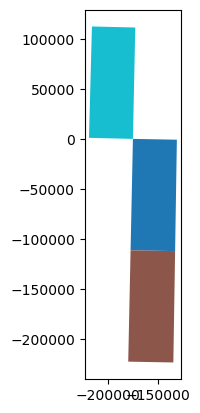

In [ ]:
# The generous bounds of the reserves
RESERVE_BOUNDS = gpd.GeoDataFrame(
    {
        "geometry":
            [
                box(xmin=-122.5, ymin=38, xmax=-122, ymax=39),
                box(xmin=-122, ymin=37, xmax=-121.5, ymax=38),
                box(xmin=-122, ymin=36, xmax=-121.5, ymax=37)
            ],
        "reserve": ["Quail", "BORR", "Hastings"]
    },
    crs=4326
)
RESERVE_BOUNDS.to_crs(WORKING_CRS, inplace=True)
RESERVE_BOUNDS.plot("reserve")

In [ ]:
def plot_map(gdf, title=None, class_column="class_names"):
    ax = gdf.plot(class_column, cmap="tab10", vmin=-0.5, vmax=9.5, legend=True, categorical=False)
    if title is not None:
        ax.set_title(title)

def compute_standardized(
    preds: gpd.GeoDataFrame, shared_region: shapely.Geometry, reserve: str, year: int, ensure_nonoverlapping=False
):
    if len(preds) == 0:
        return None

    if ensure_nonoverlapping:
        # Since geofileops requires files to be on disk, we create a temporary directory to hold
        # all the intermediate files. All the content will be deleted when the directory object
        temp_dir = tempfile.TemporaryDirectory()
        preds_file = Path(temp_dir.name, "preds.gpkg")
        shared_region_file = Path(temp_dir.name, "shared_region.gpkg")
        clipped_file = Path(temp_dir.name, "clipped.gpkg")

        # Write the files to disk so they can be clipped
        preds.to_file(preds_file)
        shared_region.to_file(shared_region_file)
        print("About to clip")
        gfo.clip(
            input_path=preds_file,
            output_path=clipped_file,
            clip_path=shared_region_file,
        )
        clipped = gpd.read_file(clipped_file)
        print("About to merge by voting")
        subset = merge_classified_polygons_by_voting(clipped, "class_ID")

        class_names_numpy = np.array(CLASS_NAMES)
        class_IDs = subset["class_ID"].astype(float).astype(int).tolist()
        print(class_names_numpy)
        print(class_IDs)
        subset["class_names"] = class_names_numpy[class_IDs]
        print("Done merging")
    else:
        # Merge all instances of the same class across all predicted datasets
        dissolved = preds.dissolve(by="class_names", as_index=False)
        plot_map(dissolved, title=f"{year}: before clipping")

        subset = dissolved.clip(shared_region)

    plot_map(subset, title=f"{year}: after clipping")
    plt.savefig(Path(f"../../data/vis/final_cover_{reserve}_{year}.png"))

    subset = ensure_projected_CRS(subset)
    # Clean up the geometry
    subset.geometry = subset.buffer(0)
    # Compute the area fraction
    total_area = (
        gpd.GeoDataFrame(data={"geometry": shared_region})
        .to_crs(subset.crs)
        .area.values[0]
    )

    subset["area_fraction"] = subset.area / total_area
    subset.to_file(Path(f"../../data/vis/final_cover_{reserve}_{year}.gpkg"))

    return subset


def compute_transition_matrix(first_class_df, second_class_df, reserve, first_year=None, second_year=None):
    overlay = first_class_df.overlay(second_class_df)

    # Get the classes for the left and right dataframes
    i_inds = overlay["class_ID_1"].to_numpy().astype(int)
    j_inds = overlay["class_ID_2"].to_numpy().astype(int)
    # Get the areas of the overlaps
    values = overlay.area.to_numpy()

    # Build a matrix to populate
    transition_matrix = np.zeros((8, 8))
    transition_matrix[i_inds, j_inds] = values
    transition_matrix_row_normed = transition_matrix / np.expand_dims(
        transition_matrix.sum(axis=1), axis=1
    )

    # Compute the years from the dataframes if not provided
    if first_year is None:
        first_year = (
            first_class_df["earliest_datetime_local_derived"]
            .dt.strftime("%Y")
            .astype(int)[0]
        )
    if second_year is None:
        second_year = (
            second_class_df["earliest_datetime_local_derived"]
            .dt.strftime("%Y")
            .astype(int)[0]
        )

    # Display the results
    ConfusionMatrixDisplay(transition_matrix, display_labels=CLASS_NAMES).plot()
    plt.title(f"Transition matrix for {reserve} for {first_year}-{second_year}")
    plt.xticks(rotation=70)
    plt.savefig(
        Path(f"../../data/vis/transition_{reserve}_{first_year}_{second_year}.png")
    )
    plt.show()
    # Show the results with each row normalized to a sum of one
    ConfusionMatrixDisplay(
        transition_matrix_row_normed, display_labels=CLASS_NAMES
    ).plot()
    plt.title(
        f"Transition matrix (row-normalized) for {reserve} for {first_year}-{second_year}"
    )
    plt.xticks(rotation=70)
    plt.savefig(
        Path(
            f"../../data/vis/transition_normalized_{reserve}_{first_year}_{second_year}.png"
        )
    )
    plt.show()

# Read the metadata 
This is taken from the ingest step and contains the time each mission was collected

In [ ]:
metadata = gpd.read_file(METADATA_FILE)
# Subset to the datetime column (needed for leaf-on/off) and the mission_id, needed for linking
metadata = metadata[["mission_id", "earliest_datetime_local_derived"]]

# Load predictions
The geospatial predictions for each dataset are saved individually to disk. Load them and concatenate them into a dataframe. Additionally record which dataset each prediction came from.

   class_ID         class_names  \
0       7.0             W_water   
1       2.0  MM_man_made_object   
2       6.0        TL_tree_live   
3       0.0       BE_bare_earth   
4       4.0       SL_shrub_live   
5       5.0        TD_tree_dead   
6       3.0       SD_shrub_dead   
7       1.0  HL_herbaceous_live   

                                            geometry mission_id  
0  MULTIPOLYGON (((-121.73292 37.3897, -121.73296...     000559  
1  MULTIPOLYGON (((-121.70993 37.37809, -121.7099...     000559  
2  MULTIPOLYGON (((-121.70002 37.38689, -121.7000...     000559  
3  MULTIPOLYGON (((-121.70379 37.38887, -121.7037...     000559  
4  MULTIPOLYGON (((-121.70072 37.3877, -121.70072...     000559  
5  MULTIPOLYGON (((-121.69937 37.38778, -121.6993...     000559  
6  MULTIPOLYGON (((-121.74165 37.39152, -121.7416...     000559  
7  POLYGON ((-121.72359 37.38732, -121.72361 37.3...     000559  


<Axes: >

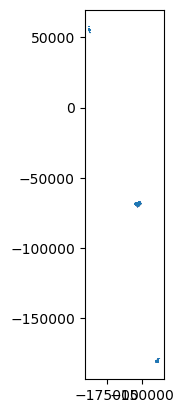

In [ ]:
# Find all predicted maps in the folder
pred_files = sorted(PREDS_FOLDER.glob("*"))

preds = []
for pred_file in pred_files:
    # Load the predicted map for one dataset
    pred = gpd.read_file(pred_file)
    # Add the mission ID information so it's tracked in the future
    pred["mission_id"] = pred_file.stem

    preds.append(pred)

all_preds = pd.concat(preds)
# All the preds are in lat-lon. Convert to a more appropriate CRS for geometric operations.
all_preds.to_crs(WORKING_CRS, inplace=True)
all_preds.plot()

# Add additional information
Add metadata from the ingest pipeline based on the mission ID. Also record which reserve each dataset is from. Finally, remove datasets that are captured during leaf-off periods if requested.

In [ ]:
# Combine the metadata with the predictions
all_preds = all_preds.merge(metadata, on="mission_id")

# Restrict to the time period that leaves would be one
if ONLY_LEAF_ON:
    # Extract the mmdd representation of the month and day
    int_month_day = all_preds["earliest_datetime_local_derived"].dt.strftime('%m%d').astype(int)

    index = (int_month_day > LEAF_ON_START_DATE) & (int_month_day < LEAF_ON_END_DATE)

    print(f"{len(index) - index.sum()} rows dropped")
    all_preds = all_preds[index]

# Add the information about which reserve it corresponds to
all_preds = gpd.sjoin(all_preds, RESERVE_BOUNDS, how="left", predicate="intersects")

166 rows dropped


Subset to a single reserve

In [9]:
# Select data only from one reserve if requested
if RESERVE is not None:
    reserve_preds = all_preds[all_preds["reserve"] == RESERVE]
else:
    reserve_preds = all_preds

Split by year

In [10]:
year = reserve_preds["earliest_datetime_local_derived"].dt.year

preds_2020 = reserve_preds[year == 2020]
preds_2023 = reserve_preds[year == 2023]
preds_2024 = reserve_preds[year == 2024]
print(f"There are {preds_2020['mission_id'].unique()} from 2020, {preds_2023['mission_id'].unique()} from 2023, and {preds_2024['mission_id'].unique()} from 2024")

There are ['000546' '000547' '000548' '000549' '000551' '000555' '000558' '000559'
 '000563' '001336' '001337'] from 2020, ['000610' '000611' '000612' '000613'] from 2023, and [] from 2024


Compute the shared region across non-empty reserves

<Axes: >

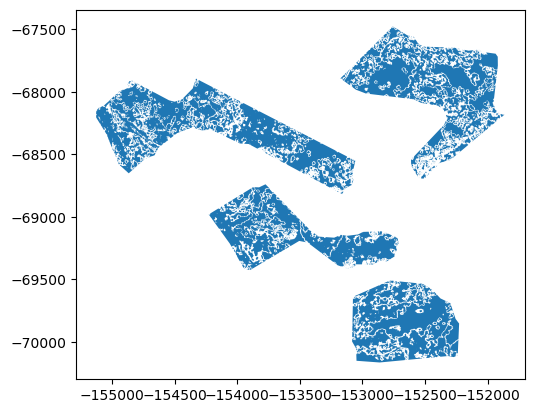

In [11]:
boundary_2020 = preds_2020.dissolve()
boundary_2023 = preds_2023.dissolve()
boundary_2024 = preds_2024.dissolve()

# We do some extra work to make this robust to years that have no data and exclude them from the calculation of the intersection
# Compute the union of all the reserves
shared_region = pd.concat((boundary_2020, boundary_2023, boundary_2024)).dissolve()

if len(boundary_2020) > 0:
    shared_region = shared_region.intersection(boundary_2020)
if len(boundary_2023) > 0:
    shared_region = shared_region.intersection(boundary_2023)
if len(boundary_2024) > 0:
    shared_region = shared_region.intersection(boundary_2024)

shared_region.plot()

## Standardize the predictions

In [ ]:
if True:
    standardized_2020 = compute_standardized(preds_2020, shared_region, reserve=RESERVE, year="2020", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
    standardized_2023 = compute_standardized(preds_2023, shared_region, reserve=RESERVE, year="2023", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
    standardized_2024 = compute_standardized(preds_2024, shared_region, reserve=RESERVE, year="2024", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
else:
    import geopandas as gpd
    standardized_2020 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2020.gpkg")
    standardized_2023 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2023.gpkg")
    standardized_2024 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2024.gpkg")

About to clip
About to merge by voting


Make a table to summarize the class fractions per

In [ ]:
final_table = np.zeros((8,3))

standardized_2020["class_ID"] = standardized_2020["class_ID"].astype(float).astype(int)
standardized_2023["class_ID"] = standardized_2023["class_ID"].astype(float).astype(int)
#standardized_2024["class_ID"] = standardized_2024["class_ID"].astype(float).astype(int)

if standardized_2020 is not None:
    final_table[standardized_2020["class_ID"].to_numpy(), 0] = standardized_2020["area_fraction"]
if standardized_2023 is not None:
    final_table[standardized_2023["class_ID"].to_numpy(), 1] = standardized_2023["area_fraction"]
if standardized_2024 is not None:
    final_table[standardized_2024["class_ID"].to_numpy(), 2] = standardized_2024["area_fraction"]

final_table_vis = pd.DataFrame(
    data=final_table,
    columns=["2020", "2023", "2024"],
    index=CLASS_NAMES)
final_table_vis

NameError: name 'np' is not defined

In [ ]:
if standardized_2020 is not None and standardized_2023 is not None:
    compute_transition_matrix(standardized_2020, standardized_2023, reserve=RESERVE, first_year="2020", second_year="2023")

if standardized_2020 is not None and standardized_2024 is not None:
    compute_transition_matrix(standardized_2020, standardized_2024, reserve=RESERVE, first_year="2020", second_year="2024")

if standardized_2023 is not None and standardized_2024 is not None:
    compute_transition_matrix(standardized_2023, standardized_2024, reserve=RESERVE, first_year="2023", second_year="2024")

# Merged 2023-2024

This section repeats the last few steps of the last section but after merging the 2023 and 2024 years since they both occured after significant regrowth

In [ ]:
preds_2023_2024 = pd.concat([preds_2023, preds_2024])

boundary_2020 = preds_2020.dissolve()
boundary_2023_2024 = preds_2023_2024.dissolve()

# We do some extra work to make this robust to years that have no data and exclude them from the calculation of the intersection
# Compute the union of all the reserves
shared_region = pd.concat((boundary_2020, boundary_2023_2024)).dissolve()

if len(boundary_2020) > 0:
    shared_region = shared_region.intersection(boundary_2020)
if len(boundary_2023_2024) > 0:
    shared_region = shared_region.intersection(boundary_2023_2024)

shared_region.plot()

In [ ]:
standardized_2020 = compute_standardized(preds_2020, shared_region, reserve=RESERVE, year="2020-merged-years", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
standardized_2023_2024 = compute_standardized(preds_2023_2024, shared_region, reserve=RESERVE, year="2023-2024", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)

In [ ]:
#standardized_2020 = compute_standardized(preds_2020, shared_region, reserve=RESERVE, year="2020", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
#standardized_2020.query("class_names == 'BE_bare_earth'")["geometry"]

In [ ]:
final_table = np.zeros((8,2))

if standardized_2020 is not None:
    final_table[standardized_2020["class_ID"].to_numpy().astype(int), 0] = standardized_2020["area_fraction"]
if standardized_2023_2024 is not None:
    final_table[standardized_2023_2024["class_ID"].to_numpy().astype(int), 1] = standardized_2023_2024["area_fraction"]

final_table_vis = pd.DataFrame(
    data=final_table,
    columns=["2020", "2023-2024"],
    index=CLASS_NAMES)
final_table_vis

In [ ]:
if standardized_2020 is not None and standardized_2023_2024 is not None:
    compute_transition_matrix(standardized_2020, standardized_2023_2024, reserve=RESERVE, first_year="2020-merged-years", second_year="2023-2024")